In [27]:
import pandas as pd
import geopandas as gpd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib

from data.sources import destatis_sources, bkg_source, processed_dir

# Elterngeld: Basisdaten von destatis

Hier führen wir einige Grunddaten ein, die bei destatis verfügbar sind.

## Geburten

Die Zahl der Geburten dient als Grundlage, ohne die Schwankungen beim Elterngeldbezug nicht zu verstehen sind.
Da die Spanne zwischen Bremen und NRW sehr groß ist und wir uns mehr für Unterschiede in den relativen Geburtenraten zwischen Ländern und über die Jahre hinweg interessieren, skalieren wir die Geburtenrate auf "Geburten je 100.000 Einwohner:innen".
Die Tabelle enthält auch das Geschlecht des Kindes, das ignorieren wir hier.

In [28]:
gb = pd.read_parquet(destatis_sources["geburten"]["processed_file"])
gb = gb.groupby(["jahr", "land"]).geburten.sum().to_frame().reset_index()

ewz = pd.read_parquet(destatis_sources["ewz"]["processed_file"])

gb = pd.merge(gb, ewz, on=["jahr", "land"])
gb["geburten_pro_1000"] = gb.geburten / gb.ewz * 1000

fig = go.Figure()

for land, grp in gb.groupby("land"):
    fig.add_trace(
        go.Scatter(
            x=grp.jahr,
            y=grp.geburten_pro_1000,
            mode="markers+lines",
            name=land
        ),
    )

fig.update_layout(
    width=1000,
    height=800,
    margin=dict(t=20, r=20, b=20, l=20)
)

fig.show()

Interessant ist wie 2021/22 in den alten Bundesländern die Zahl wieder steigt, aber in den neuen sich der Abwärtstrend nicht umkehrt.
Möglicherweise gibt es Geschlechterunterschiede in Wanderungsbewegungen?
Die Geburtenrate pro Mutter wäre interessant.

## Empfangende von Elterngeld


In [29]:
eg = pd.read_parquet(destatis_sources["eg_empf"]["processed_file"])

eg = eg.loc[eg.art.eq("Insgesamt")]
eg = eg.loc[eg.fm.ne("Insgesamt")]

eg = eg.groupby(["jahr", "land", "fm", "art"]).sum().drop("quartal", axis=1).reset_index()

eg["grp_display"] = eg.apply(
    lambda row: f"{'Mütter' if row.fm=='weiblich' else 'Väter'} in {row.land}",
    axis=1
)

eg = eg.sort_values(by=["jahr", "land", "fm"], ascending=[True, True, False]).reset_index(drop=True)
land_clr = {
    'Schleswig-Holstein': '#1f77b4',
    'Hamburg': '#ff7f0e',
    'Niedersachsen': '#2ca02c',
    'Bremen': '#d62728',
    'Nordrhein-Westfalen': '#9467bd',
    'Hessen': '#8c564b',
    'Rheinland-Pfalz': '#e377c2',
    'Baden-Württemberg': '#7f7f7f',
    'Bayern': '#bcbd22',
    'Saarland': '#17becf',
    'Berlin': '#aec7e8',
    'Brandenburg': '#ffbb78',
    'Mecklenburg-Vorpommern': '#98df8a',
    'Sachsen': '#ff9896',
    'Sachsen-Anhalt': '#c5b0d5',
    'Thüringen': '#c49c94',
}

fm_line = {
    "weiblich": "solid",
    "männlich": "dash",
}

fig = go.Figure()

for var, grp in eg.groupby(["land", "fm"]):
    fig.add_trace(
        go.Scatter(
            x=grp.jahr,
            y=grp.pers,
            mode="markers+lines",
            line=dict(
                dash=fm_line[var[1]],
                color=land_clr[var[0]]
            ),
            name=var[0],
            showlegend=var[1]=="weiblich",
            legendgroup=var[0],
            visible=True if var[0] == "Berlin" else "legendonly",
            customdata=grp.grp_display.values,
            hovertemplate="%{customdata}: %{y:f}<extra></extra>"
        )
    )

fig.update_layout(
    hovermode="x unified",
    width=1000,
    height=550,
    margin=dict(t=50, r=20, b=20, l=20),
    yaxis=dict(
        range=[0, eg.pers.max()],
        tickformat=".0f"
    ),
    title="Empfänger:innen von Elterngeld"
)

fig.show()

# Empfänger:innen von Elterngeld in Prozent Anteil an Geburten

In [30]:
egb = pd.merge(
    eg,
    gb[["jahr", "land", "geburten"]],
    on=["jahr", "land"],
    how="left"
)
egb["eg_rate"] = egb.pers / egb.geburten * 100

fig = go.Figure()

for var, grp in egb.groupby(["land", "fm"]):
    fig.add_trace(
        go.Scatter(
            x=grp.jahr,
            y=grp.eg_rate,
            mode="markers+lines",
            line=dict(
                dash=fm_line[var[1]],
                color=land_clr[var[0]]
            ),
            name=var[0],
            showlegend=var[1]=="weiblich",
            legendgroup=var[0],
            visible=True if var[0] == "Berlin" else "legendonly",
            customdata=grp.grp_display.values,
            hovertemplate="%{customdata}: bei %{y:.1f}% der geborenen Kinder<extra></extra>"
        )
    )

fig.update_layout(
    hovermode="x unified",
    width=1000,
    height=800,
    margin=dict(t=20, r=20, b=20, l=20),
    yaxis=dict(range=[0, egb.eg_rate.max()])
)

fig.show()

# Dauer des Bezugs ~ Steuerkraft

## Teil 1: Dauer des Bezugs als Karte

Daten liegen in Langform vor. Wir formen hin zu einer Zeile pro Kreis und Jahr.

In [31]:
df_dauer_krs = pd.read_parquet(destatis_sources["eg_dauer"]["processed_file"])

# viele heute eingestellte Kreise mit fehlenden Daten; entfernen:
df_dauer_krs = df_dauer_krs.dropna(subset="monate")

df_dauer_krs

,jahr,krs,fm,egplus,monate
18,2016,"Ahrweiler, Landkreis",Insgesamt,Insgesamt,12.0
19,2016,"Ahrweiler, Landkreis",Insgesamt,Mit Elterngeld Plus,19.5
20,2016,"Ahrweiler, Landkreis",Insgesamt,Ohne Elterngeld Plus,9.7
21,2016,"Ahrweiler, Landkreis",männlich,Insgesamt,3.3
22,2016,"Ahrweiler, Landkreis",männlich,Mit Elterngeld Plus,7.4
...,...,...,...,...,...
34247,2023,"Zwickau, Landkreis",Insgesamt,Ohne Elterngeld Plus,8.0
34249,2023,"Zwickau, Landkreis",männlich,Mit Elterngeld Plus,6.5
34251,2023,"Zwickau, Landkreis",weiblich,Insgesamt,14.5
34252,2023,"Zwickau, Landkreis",weiblich,Mit Elterngeld Plus,17.8


In [32]:
# Geschlecht und EG-Plus zu Spalten machen:
dd_piv = df_dauer_krs.pivot(index=["jahr", "krs"], columns=["fm", "egplus"], values="monate").reset_index()
dd_piv

fm      jahr                                   krs Insgesamt  \
egplus                                             Insgesamt   
0       2016                  Ahrweiler, Landkreis      12.0   
1       2016          Aichach-Friedberg, Landkreis      10.3   
2       2016                       Alb-Donau-Kreis      10.4   
3       2016           Altenburger Land, Landkreis      11.9   
4       2016  Altenkirchen (Westerwald), Landkreis      13.1   
...      ...                                   ...       ...   
3203    2023                   Würzburg, Landkreis      10.9   
3204    2023            Würzburg, kreisfreie Stadt      10.7   
3205    2023                       Zollernalbkreis      12.2   
3206    2023         Zweibrücken, kreisfreie Stadt      13.4   
3207    2023                    Zwickau, Landkreis      11.1   

fm                                               männlich                      \
egplus Mit Elterngeld Plus Ohne Elterngeld Plus Insgesamt Mit Elterngeld Plus   
0                     19.5                  9.7       3.3                 7.4   
1                     18.5                  9.0       3.2                 9.0   
2                     18.8                  8.9       2.8                 7.9   
3                     18.6                  9.3       3.2                 8.0   
4                     20.9                  9.7       3.4                10.4   
...                    ...                  ...       ...                 ...   
3203                  17.5                  8.0       3.2                 8.1   
3204                  16.5                  8.5       4.0                 8.4   
3205                  18.9                  8.1      <NA>                 7.2   
3206                  19.9                  9.3       3.2                 5.7   
3207                  16.5                  8.0      <NA>                 6.5   

fm                           weiblich                                           
egplus Ohne Elterngeld Plus Insgesamt Mit Elterngeld Plus Ohne Elterngeld Plus  
0                       2.7      14.0                20.8                 11.7  
1                       2.8      13.0                20.1                 11.6  
2                       2.5      13.3                20.3                 11.7  
3                       2.9      14.3                19.1                 11.8  
4                       2.7      15.1                21.4                 11.8  
...                     ...       ...                 ...                  ...  
3203                   <NA>      14.5                19.2                 11.7  
3204                   <NA>      13.7                18.6                 11.4  
3205                   <NA>      15.7                20.1                 11.6  
3206                   <NA>      15.4                20.5                 11.4  
3207                   <NA>      14.5                17.8                 11.7  

[3208 rows x 11 columns]

Hier wird etwas klarer, was für Daten fehlen (Zahl der Kreise ist 401):

In [33]:
dd_piv.set_index("jahr").isna().groupby("jahr").agg("sum")

fm     krs Insgesamt                                           männlich  \
egplus     Insgesamt Mit Elterngeld Plus Ohne Elterngeld Plus Insgesamt   
jahr                                                                      
2016     0         0                   0                    0         0   
2017     0         0                   0                    0         0   
2018     0         0                   0                    0         0   
2019     0         0                   0                    0       110   
2020     0         0                   0                    0       105   
2021     0         0                   0                    0       102   
2022     0         0                   0                    0        94   
2023     0         0                   0                    0        71   

fm                                               weiblich                      \
egplus Mit Elterngeld Plus Ohne Elterngeld Plus Insgesamt Mit Elterngeld Plus   
jahr                                                                            
2016                     0                    0         0                   0   
2017                     0                    0         0                   0   
2018                     0                    0         0                   0   
2019                     0                  303         0                   0   
2020                     0                  321         0                   0   
2021                     0                  331         0                   0   
2022                     0                  340         0                   0   
2023                     0                  339         0                   0   

fm                           
egplus Ohne Elterngeld Plus  
jahr                         
2016                      0  
2017                      0  
2018                      0  
2019                      0  
2020                      0  
2021                      0  
2022                      0  
2023                      0

Ab 2019 fehlen die Daten zu den Vätern in beträchtlichem Maße - ein Viertel der Gesamtwerte und 75% der Werte ohne EG-Plus.
Scheint als wären wir da bei den Vätern auf die mit EG Plus angewiesen.

Wir matchen die EG-Daten auf Kreisebene mit Geodaten aus der VG250 des Bundesamts für Kartografie und Geodäsie. Warum? Weil wir nur so die Benennungen der Kreise im EG-Datensatz mit tatsächlichen Entitäten verbinden können, die eindeutig identifiziert sind und für die es z.B. Geometriedaten gibt. Die Benennung der Kreise im EG-Datensatz ist zudem etwas unsauber und das wollen wir korrigieren.

In [34]:
# Geodaten laden:
vg_krs = gpd.read_parquet(bkg_source["processed_file"]).to_crs(epsg=4326)

# Seegebiete ausschließen:
vg_krs = vg_krs.loc[vg_krs.GF.ne(2)]

# schönere Spaltennamen:
columns = {
    "AGS_0": "ags",
    "GEN": "gen",
    "BEZ": "bez",
    "EWZ": "ewz",
    "geometry": "geom",
}
vg_krs = vg_krs.filter(columns).rename(columns, axis=1)

# Unser erster Match-Versuch nutzt die Tatsache, dass im EG-Datensatz die Kreise benannt sind nach der Form:
# "<NAME>, <BEZEICHNUNG>".
# Wir konstruieren im gdf eine neue Spalte aus "gen" & "bez", die das reproduziert.

# Dafür müssen wir die Großschreibung korrigieren:
vg_krs.loc[vg_krs.bez.eq("Kreisfreie Stadt"), "bez"] = "kreisfreie Stadt"

vg_krs["krs"] = vg_krs.gen + ", " + vg_krs.bez
vg_krs

,ags,gen,bez,ewz,geom,krs
0,01001000,Flensburg,kreisfreie Stadt,91113,"MULTIPOLYGON (((9.41266 54.82264, 9.41318 54.8...","Flensburg, kreisfreie Stadt"
1,01002000,Kiel,kreisfreie Stadt,246243,"MULTIPOLYGON (((10.16916 54.43138, 10.16957 54...","Kiel, kreisfreie Stadt"
2,01003000,Lübeck,kreisfreie Stadt,216277,"MULTIPOLYGON (((10.87684 53.98737, 10.87884 53...","Lübeck, kreisfreie Stadt"
3,01004000,Neumünster,kreisfreie Stadt,79496,"MULTIPOLYGON (((9.99545 54.14972, 9.99713 54.1...","Neumünster, kreisfreie Stadt"
4,01051000,Dithmarschen,Kreis,133969,"MULTIPOLYGON (((9.07777 54.36249, 9.07916 54.3...","Dithmarschen, Kreis"
...,...,...,...,...,...,...
395,16073000,Saalfeld-Rudolstadt,Landkreis,100969,"MULTIPOLYGON (((11.26298 50.83328, 11.26504 50...","Saalfeld-Rudolstadt, Landkreis"
396,16074000,Saale-Holzland-Kreis,Landkreis,82513,"MULTIPOLYGON (((11.69798 51.08352, 11.69817 51...","Saale-Holzland-Kreis, Landkreis"
397,16075000,Saale-Orla-Kreis,Landkreis,79030,"MULTIPOLYGON (((11.83003 50.78988, 11.83030 50...","Saale-Orla-Kreis, Landkreis"
398,16076000,Greiz,Landkreis,96102,"MULTIPOLYGON (((12.19167 50.96358, 12.19448 50...","Greiz, Landkreis"


Wir füllen `df_dauer_matched` nach und nach mit den Matches zwischen `df_dauer_krs` und der `vg_krs`.

Erster Join: die `krs`-Spalte im EG-Datensatz entspricht der Form "@gen, @bez"; das machen wir uns zunutze:

In [35]:
df_dauer_matched = pd.merge(df_dauer_krs, vg_krs, on="krs")

# Nichtmatches:
df_dauer_mismatch = df_dauer_krs.query('~krs.isin(@df_dauer_matched.krs)')
df_dauer_mismatch

,jahr,krs,fm,egplus,monate
36,2016,Alb-Donau-Kreis,Insgesamt,Insgesamt,10.4
37,2016,Alb-Donau-Kreis,Insgesamt,Mit Elterngeld Plus,18.8
38,2016,Alb-Donau-Kreis,Insgesamt,Ohne Elterngeld Plus,8.9
39,2016,Alb-Donau-Kreis,männlich,Insgesamt,2.8
40,2016,Alb-Donau-Kreis,männlich,Mit Elterngeld Plus,7.9
...,...,...,...,...,...
34229,2023,Zollernalbkreis,Insgesamt,Ohne Elterngeld Plus,8.1
34231,2023,Zollernalbkreis,männlich,Mit Elterngeld Plus,7.2
34233,2023,Zollernalbkreis,weiblich,Insgesamt,15.7
34234,2023,Zollernalbkreis,weiblich,Mit Elterngeld Plus,20.1


Zweiter Join: die Bezeichnung des Kreises (Stadtkreis, Landkreis, kreisfreie Stadt, ...) ist bei einigen Orten Teil von `gen`; wir matchen die bisherigen Überbleibsel, die deswegen nicht gematcht haben und die erfolgreichen Matches wandern in df_dauer_matched:

In [36]:
df_dauer_matched = pd.concat([
    df_dauer_matched,
    pd.merge(df_dauer_mismatch, vg_krs.drop("krs", axis=1), left_on="krs", right_on="gen")
])
df_dauer_mismatch = df_dauer_krs.query('~krs.isin(@df_dauer_matched.krs)')
df_dauer_mismatch

,jahr,krs,fm,egplus,monate
279,2016,"Baden-Baden, kreisfreie Stadt",Insgesamt,Insgesamt,11.3
280,2016,"Baden-Baden, kreisfreie Stadt",Insgesamt,Mit Elterngeld Plus,18.3
281,2016,"Baden-Baden, kreisfreie Stadt",Insgesamt,Ohne Elterngeld Plus,9.8
282,2016,"Baden-Baden, kreisfreie Stadt",männlich,Insgesamt,3.2
283,2016,"Baden-Baden, kreisfreie Stadt",männlich,Mit Elterngeld Plus,6.5
...,...,...,...,...,...
34194,2023,"Wunsiedel im Fichtelgebirge, Landkreis",männlich,Insgesamt,3.3
34195,2023,"Wunsiedel im Fichtelgebirge, Landkreis",männlich,Mit Elterngeld Plus,7.0
34197,2023,"Wunsiedel im Fichtelgebirge, Landkreis",weiblich,Insgesamt,15.0
34198,2023,"Wunsiedel im Fichtelgebirge, Landkreis",weiblich,Mit Elterngeld Plus,19.7


Dritter & vierter Join: Einige Kreise, die im EG-Datensatz "Landkreis" oder "kreisfreie Stadt" heißen, heißen in der vg250 "Kreis" oder "Stadtkreis":

In [37]:
vg_krs.krs = vg_krs.krs.str.replace("Kreis", "Landkreis")
df_dauer_matched = pd.concat([
    df_dauer_matched,
    pd.merge(df_dauer_mismatch, vg_krs, on="krs")
])
df_dauer_mismatch = df_dauer_krs.query('~krs.isin(@df_dauer_matched.krs)')
df_dauer_mismatch

,jahr,krs,fm,egplus,monate
279,2016,"Baden-Baden, kreisfreie Stadt",Insgesamt,Insgesamt,11.3
280,2016,"Baden-Baden, kreisfreie Stadt",Insgesamt,Mit Elterngeld Plus,18.3
281,2016,"Baden-Baden, kreisfreie Stadt",Insgesamt,Ohne Elterngeld Plus,9.8
282,2016,"Baden-Baden, kreisfreie Stadt",männlich,Insgesamt,3.2
283,2016,"Baden-Baden, kreisfreie Stadt",männlich,Mit Elterngeld Plus,6.5
...,...,...,...,...,...
34194,2023,"Wunsiedel im Fichtelgebirge, Landkreis",männlich,Insgesamt,3.3
34195,2023,"Wunsiedel im Fichtelgebirge, Landkreis",männlich,Mit Elterngeld Plus,7.0
34197,2023,"Wunsiedel im Fichtelgebirge, Landkreis",weiblich,Insgesamt,15.0
34198,2023,"Wunsiedel im Fichtelgebirge, Landkreis",weiblich,Mit Elterngeld Plus,19.7


In [38]:
vg_krs.krs = vg_krs.krs.str.replace("Stadtkreis", "kreisfreie Stadt")
df_dauer_matched = pd.concat([
    df_dauer_matched,
    pd.merge(df_dauer_mismatch, vg_krs, on="krs")
])
df_dauer_mismatch = df_dauer_krs.query('~krs.isin(@df_dauer_matched.krs)')
df_dauer_mismatch

,jahr,krs,fm,egplus,monate
783,2016,"Dillingen an der Donau, Landkreis",Insgesamt,Insgesamt,10.4
784,2016,"Dillingen an der Donau, Landkreis",Insgesamt,Mit Elterngeld Plus,19.0
785,2016,"Dillingen an der Donau, Landkreis",Insgesamt,Ohne Elterngeld Plus,9.2
786,2016,"Dillingen an der Donau, Landkreis",männlich,Insgesamt,2.7
787,2016,"Dillingen an der Donau, Landkreis",männlich,Mit Elterngeld Plus,6.4
...,...,...,...,...,...
34194,2023,"Wunsiedel im Fichtelgebirge, Landkreis",männlich,Insgesamt,3.3
34195,2023,"Wunsiedel im Fichtelgebirge, Landkreis",männlich,Mit Elterngeld Plus,7.0
34197,2023,"Wunsiedel im Fichtelgebirge, Landkreis",weiblich,Insgesamt,15.0
34198,2023,"Wunsiedel im Fichtelgebirge, Landkreis",weiblich,Mit Elterngeld Plus,19.7


Und zuletzt gibt es einfach einige Totalverluste, vor allem weil im BKG seit einiger Zeit eine neue Nomenklatur für Präpositionen im Namen gilt: abgekürzt und ohne Leerzeichen bei mehreren Wörtern. Plus, wir kürzen "Oberpfalz" und "Oldenburg" ab.

In [39]:
translatedict = {
    "Dillingen a.d. Donau, Landkreis": 'Dillingen an der Donau, Landkreis',
    "Eisenach, kreisfreie Stadt": 'Eisenach, kreisfreie Stadt (bis 30.06.2021)',
    "Mühldorf a. Inn, Landkreis": 'Mühldorf am Inn, Landkreis',
    "Neumarkt i.d. OPf., Landkreis": 'Neumarkt in der Oberpfalz, Landkreis',
    "Neustadt a.d. Aisch-Bad Windsheim, Landkreis": 'Neustadt an der Aisch-Bad Windsheim, Landkreis',
    "Neustadt a.d. Waldnaab, Landkreis": 'Neustadt an der Waldnaab, Landkreis',
    "Oldenburg (Oldb), kreisfreie Stadt": 'Oldenburg (Oldenburg), kreisfreie Stadt',
    "Pfaffenhofen a.d. Ilm, Landkreis": 'Pfaffenhofen an der Ilm, Landkreis',
    "St. Wendel, Landkreis": 'Sankt Wendel, Landkreis',
    "Weiden i.d. OPf., kreisfreie Stadt": 'Weiden in der Oberpfalz, kreisfreie Stadt',
    "Wunsiedel i. Fichtelgebirge, Landkreis": 'Wunsiedel im Fichtelgebirge, Landkreis'
}

vg_krs.krs = vg_krs.krs.replace(translatedict)

df_dauer_matched = pd.concat([
    df_dauer_matched,
    pd.merge(df_dauer_mismatch, vg_krs, on="krs")
])
df_dauer_mismatch = df_dauer_krs.query('~krs.isin(@df_dauer_matched.krs)')
df_dauer_mismatch

,jahr,krs,fm,egplus,monate
927,2016,"Eisenach, kreisfreie Stadt (bis 30.06.2021)",Insgesamt,Insgesamt,11.5
928,2016,"Eisenach, kreisfreie Stadt (bis 30.06.2021)",Insgesamt,Mit Elterngeld Plus,18.8
929,2016,"Eisenach, kreisfreie Stadt (bis 30.06.2021)",Insgesamt,Ohne Elterngeld Plus,9.0
930,2016,"Eisenach, kreisfreie Stadt (bis 30.06.2021)",männlich,Insgesamt,2.9
931,2016,"Eisenach, kreisfreie Stadt (bis 30.06.2021)",männlich,Mit Elterngeld Plus,5.6
...,...,...,...,...,...
30917,2023,"Eisenach, kreisfreie Stadt (bis 30.06.2021)",Insgesamt,Ohne Elterngeld Plus,8.7
30919,2023,"Eisenach, kreisfreie Stadt (bis 30.06.2021)",männlich,Mit Elterngeld Plus,5.5
30921,2023,"Eisenach, kreisfreie Stadt (bis 30.06.2021)",weiblich,Insgesamt,14.6
30922,2023,"Eisenach, kreisfreie Stadt (bis 30.06.2021)",weiblich,Mit Elterngeld Plus,18.6


Einzig übrig ist nur noch Eisenach, das 2021 aufgehört hat als Kreis zu existieren. Das müssen wir dann ignorieren.

In [40]:
df = gpd.GeoDataFrame(df_dauer_matched, geometry="geom")
df

,jahr,krs,fm,egplus,monate,ags,gen,bez,ewz,geom
0,2016,"Ahrweiler, Landkreis",Insgesamt,Insgesamt,12.0,07131000,Ahrweiler,Landkreis,128146,"MULTIPOLYGON (((7.20379 50.64966, 7.20462 50.6..."
1,2016,"Ahrweiler, Landkreis",Insgesamt,Mit Elterngeld Plus,19.5,07131000,Ahrweiler,Landkreis,128146,"MULTIPOLYGON (((7.20379 50.64966, 7.20462 50.6..."
2,2016,"Ahrweiler, Landkreis",Insgesamt,Ohne Elterngeld Plus,9.7,07131000,Ahrweiler,Landkreis,128146,"MULTIPOLYGON (((7.20379 50.64966, 7.20462 50.6..."
3,2016,"Ahrweiler, Landkreis",männlich,Insgesamt,3.3,07131000,Ahrweiler,Landkreis,128146,"MULTIPOLYGON (((7.20379 50.64966, 7.20462 50.6..."
4,2016,"Ahrweiler, Landkreis",männlich,Mit Elterngeld Plus,7.4,07131000,Ahrweiler,Landkreis,128146,"MULTIPOLYGON (((7.20379 50.64966, 7.20462 50.6..."
...,...,...,...,...,...,...,...,...,...,...
643,2023,"Wunsiedel im Fichtelgebirge, Landkreis",männlich,Insgesamt,3.3,09479000,Wunsiedel i. Fichtelgebirge,Landkreis,71482,"MULTIPOLYGON (((12.08858 50.22563, 12.08998 50..."
644,2023,"Wunsiedel im Fichtelgebirge, Landkreis",männlich,Mit Elterngeld Plus,7.0,09479000,Wunsiedel i. Fichtelgebirge,Landkreis,71482,"MULTIPOLYGON (((12.08858 50.22563, 12.08998 50..."
645,2023,"Wunsiedel im Fichtelgebirge, Landkreis",weiblich,Insgesamt,15.0,09479000,Wunsiedel i. Fichtelgebirge,Landkreis,71482,"MULTIPOLYGON (((12.08858 50.22563, 12.08998 50..."
646,2023,"Wunsiedel im Fichtelgebirge, Landkreis",weiblich,Mit Elterngeld Plus,19.7,09479000,Wunsiedel i. Fichtelgebirge,Landkreis,71482,"MULTIPOLYGON (((12.08858 50.22563, 12.08998 50..."


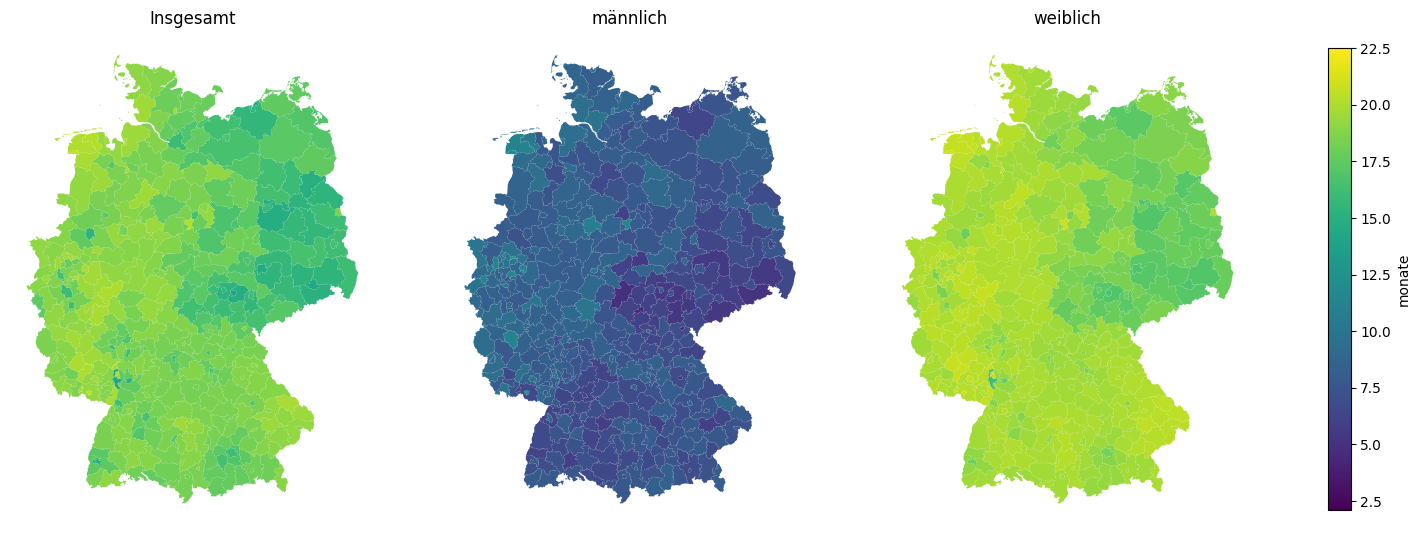

In [41]:
fig, axs = plt.subplots(
    ncols=3,
    nrows=1,
    sharex=True, sharey=True,
)

fig.set_size_inches(20, 7.5)

z_var = "monate"
xfac_var = "fm"


# globales Minimum und Maximum bei der Farb-Variable:
z_min = df[z_var].min()
z_max = df[z_var].max()

# der Teil hier ist dann als interaktiver Teil realisiert:
df_plot = df.query(
    'egplus == "Mit Elterngeld Plus"'
    'and jahr == 2023'
)

facet_var = "fm"
facets = df_plot[facet_var].unique()

cols = np.array([0, 1, 2])
subpltcoord = cols

for xy, facet in zip(subpltcoord, facets):

    df_facet = df_plot.loc[df_plot[facet_var].eq(facet)]

    x = xy
    df_facet.plot(
        ax=axs[x],
        column=z_var,
        vmin=z_min,
        vmax=z_max,
    )

    axs[x].set_title(facet)

for ax in axs:
    ax.axis("off")

cbar = plt.colorbar(axs[0].collections[0], ax=axs.ravel().tolist(), shrink=.8)
cbar.set_label(z_var)

In [92]:
n = matplotlib.colors.Normalize(0, 4)
n(.9)

0.225

# Wunschliste

- User können in der App entscheiden, welche Variable als Facette dargestellt wird
- Hover
- Zoom